In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install rarfile

In [ ]:
# import rarfile
# import os

# # Define the paths
# rar_path = "/content/drive/MyDrive/Brain Tumor Classification/Merged_Dataset_2.rar"
# extract_path = "/content/drive/MyDrive/Brain Tumor Classification/"

# # Ensure the extract directory exists
# if not os.path.exists(extract_path):
#     os.makedirs(extract_path)

# # Open the .rar file and extract
# with rarfile.RarFile(rar_path, 'r') as rf:
#     rf.extractall(extract_path)

# print("Extraction completed.")


Extraction completed.


In [ ]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [ ]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [ ]:
tr_df = train_df('/content/drive/MyDrive/Brain Tumor Classification/Merged_Dataset_1/Training')

In [ ]:
tr_df

,Class Path,Class
0,/content/drive/MyDrive/Brain Tumor Classificat...,notumor
1,/content/drive/MyDrive/Brain Tumor Classificat...,notumor
2,/content/drive/MyDrive/Brain Tumor Classificat...,notumor
3,/content/drive/MyDrive/Brain Tumor Classificat...,notumor
4,/content/drive/MyDrive/Brain Tumor Classificat...,notumor
...,...,...
5707,/content/drive/MyDrive/Brain Tumor Classificat...,meningioma
5708,/content/drive/MyDrive/Brain Tumor Classificat...,meningioma
5709,/content/drive/MyDrive/Brain Tumor Classificat...,meningioma
5710,/content/drive/MyDrive/Brain Tumor Classificat...,meningioma


In [ ]:
ts_df = test_df('/content/drive/MyDrive/Brain Tumor Classification/Merged_Dataset_1/Testing')

In [ ]:
ts_df

,Class Path,Class
0,/content/drive/MyDrive/Brain Tumor Classificat...,glioma
1,/content/drive/MyDrive/Brain Tumor Classificat...,glioma
2,/content/drive/MyDrive/Brain Tumor Classificat...,glioma
3,/content/drive/MyDrive/Brain Tumor Classificat...,glioma
4,/content/drive/MyDrive/Brain Tumor Classificat...,glioma
...,...,...
1306,/content/drive/MyDrive/Brain Tumor Classificat...,notumor
1307,/content/drive/MyDrive/Brain Tumor Classificat...,notumor
1308,/content/drive/MyDrive/Brain Tumor Classificat...,notumor
1309,/content/drive/MyDrive/Brain Tumor Classificat...,notumor


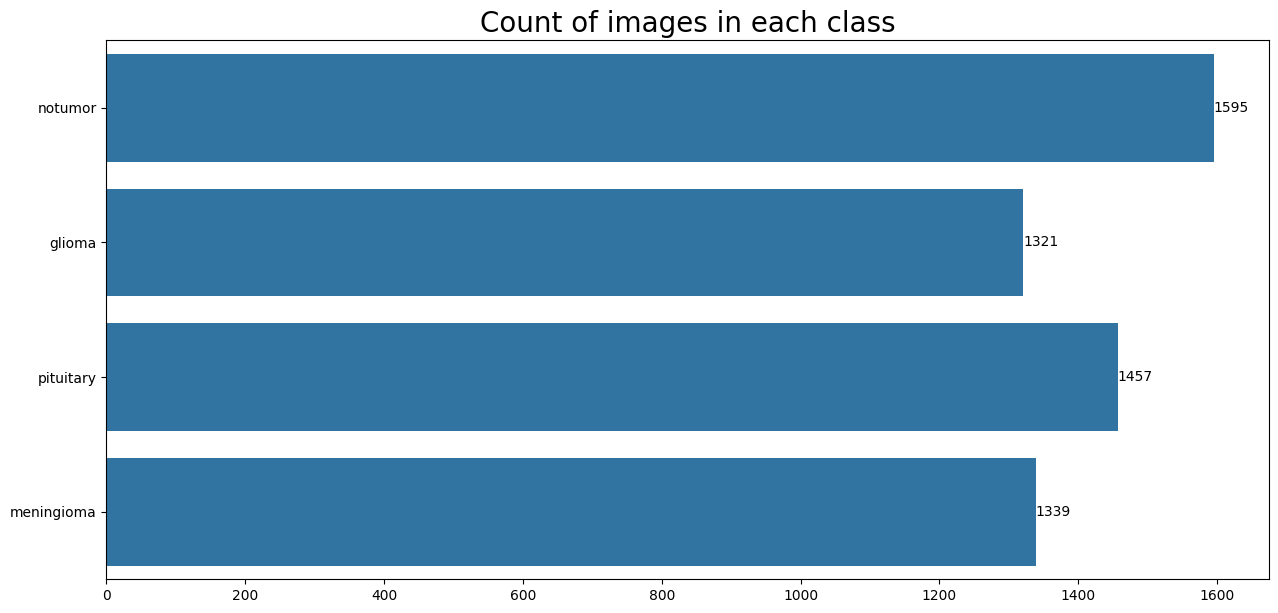

In [ ]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df , y=tr_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

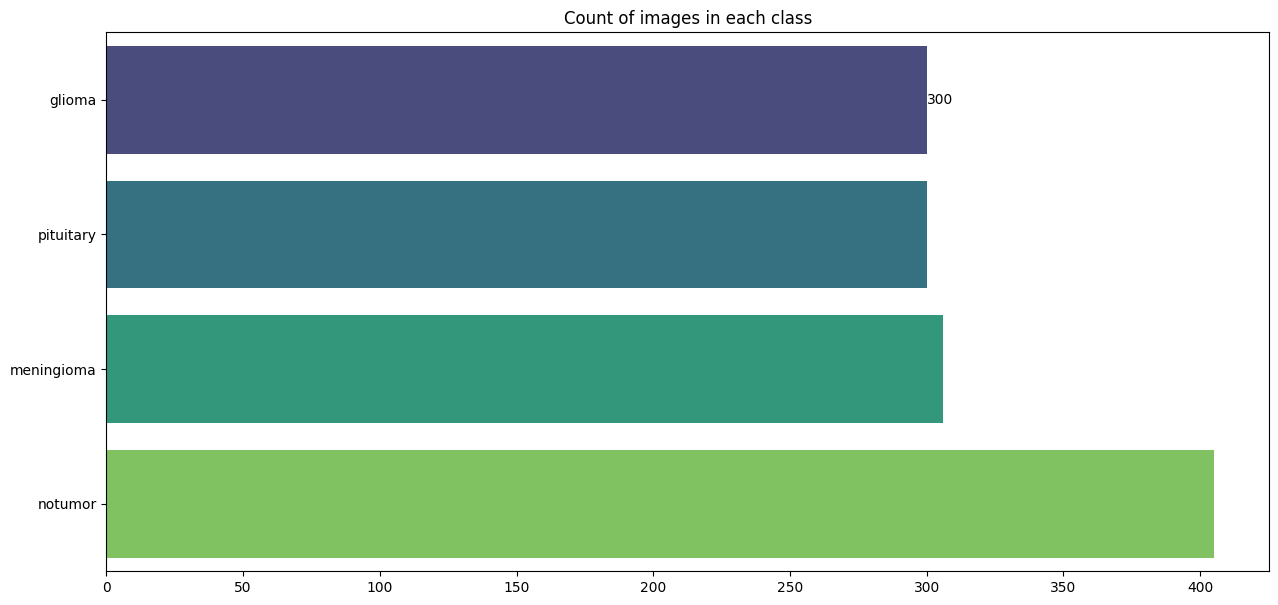

In [ ]:
#Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=ts_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

In [ ]:
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

In [ ]:
valid_df

,Class Path,Class
286,/content/drive/MyDrive/Brain Tumor Classificat...,glioma
618,/content/drive/MyDrive/Brain Tumor Classificat...,meningioma
361,/content/drive/MyDrive/Brain Tumor Classificat...,pituitary
673,/content/drive/MyDrive/Brain Tumor Classificat...,meningioma
109,/content/drive/MyDrive/Brain Tumor Classificat...,glioma
...,...,...
59,/content/drive/MyDrive/Brain Tumor Classificat...,glioma
1160,/content/drive/MyDrive/Brain Tumor Classificat...,notumor
273,/content/drive/MyDrive/Brain Tumor Classificat...,glioma
794,/content/drive/MyDrive/Brain Tumor Classificat...,meningioma


In [ ]:
batch_size = 32
img_size = (160, 160)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation and preprocessing for training
_gen = ImageDataGenerator(rescale=1./255,
                          rotation_range=10,
                           brightness_range=(0.85, 1.15),
                          width_shift_range=0.002,
                          height_shift_range=0.002,
                          shear_range=12.5,
                          zoom_range=0,
                          horizontal_flip=True,
                          vertical_flip=False,
                          fill_mode="nearest")

# Preprocessing for validation and test (without augmentation)
ts_gen = ImageDataGenerator(rescale=1./255)

# Creating training data generator
tr_gen = _gen.flow_from_dataframe(tr_df,
                                  x_col='Class Path',
                                  y_col='Class',
                                  target_size=img_size,
                                  batch_size=batch_size,
                                  class_mode='categorical',
                                  seed=0)

# Creating validation data generator
valid_gen = _gen.flow_from_dataframe(valid_df,
                                     x_col='Class Path',
                                     y_col='Class',
                                     target_size=img_size,
                                     batch_size=batch_size,
                                     class_mode='categorical',
                                     seed=0)

# Creating test data generator (without shuffling for consistent evaluation)
ts_gen = ts_gen.flow_from_dataframe(ts_df,
                                    x_col='Class Path',
                                    y_col='Class',
                                    target_size=img_size,
                                    batch_size=16,
                                    class_mode='categorical',
                                    shuffle=False,
                                    seed=0)


Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


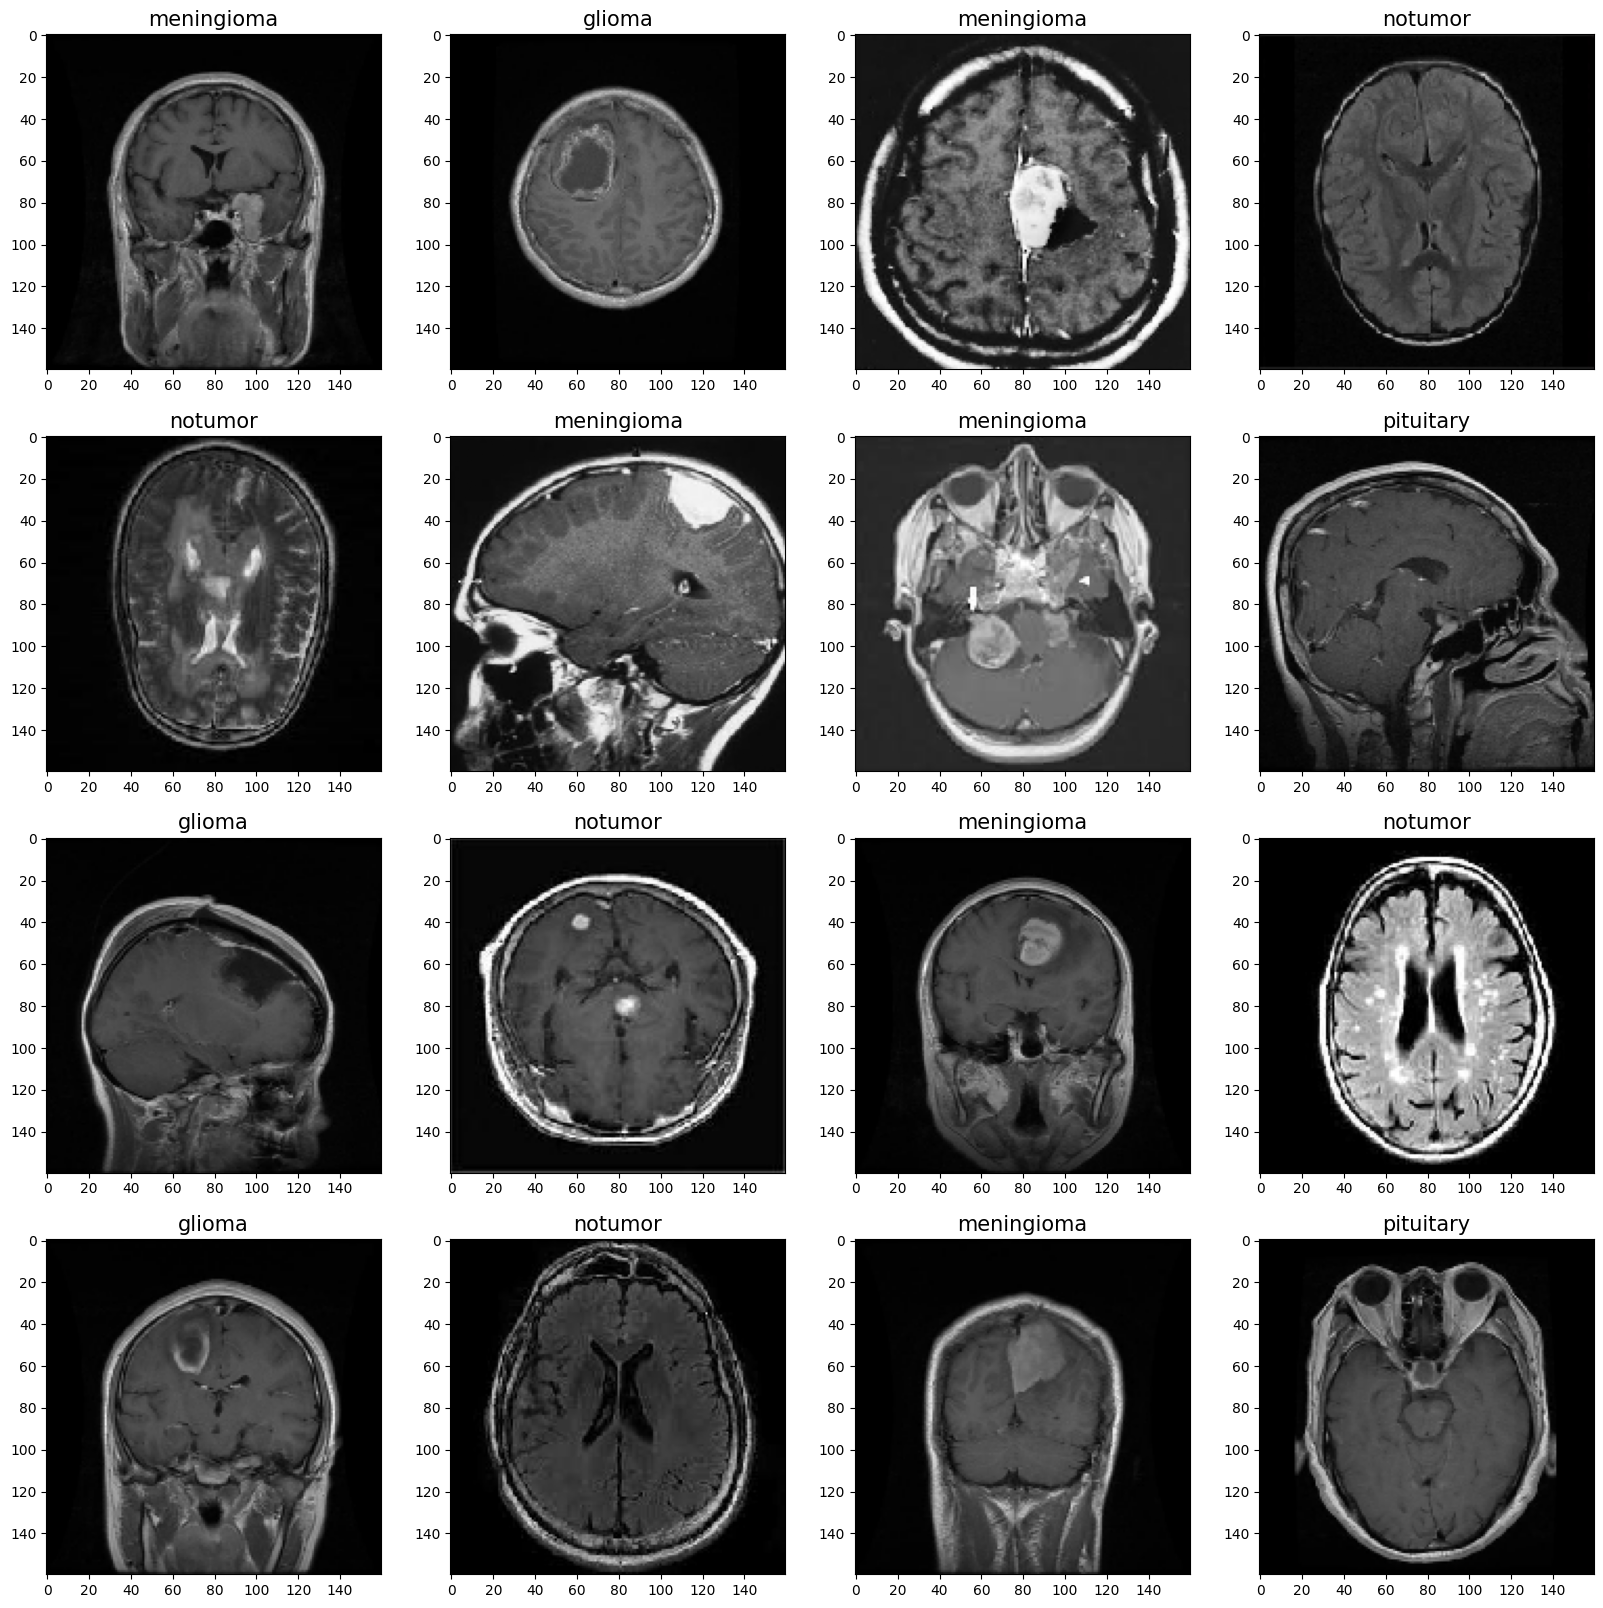

In [ ]:
class_dict = tr_gen.class_indices
classes = list(class_dict.keys())
images, labels = next(ts_gen)

plt.figure(figsize=(20, 20))

for i, (image, label) in enumerate(zip(images, labels)):
    plt.subplot(4,4, i + 1)
    plt.imshow(image)
    class_name = classes[np.argmax(label)]
    plt.title(class_name, color='k', fontsize=15)

plt.show()

In [ ]:
img_shape=(160,160,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

# for layer in base_model.layers:
#     layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate= 0.3),
    Dense(128, activation= 'relu'),
    Dropout(rate= 0.25),
    Dense(4, activation= 'softmax')
])

# Call the model with a sample input to define the output shapes
sample_input = tf.keras.Input(shape=img_shape)  # Create a sample input tensor
_ = model(sample_input)  # Call the model to infer shapes

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

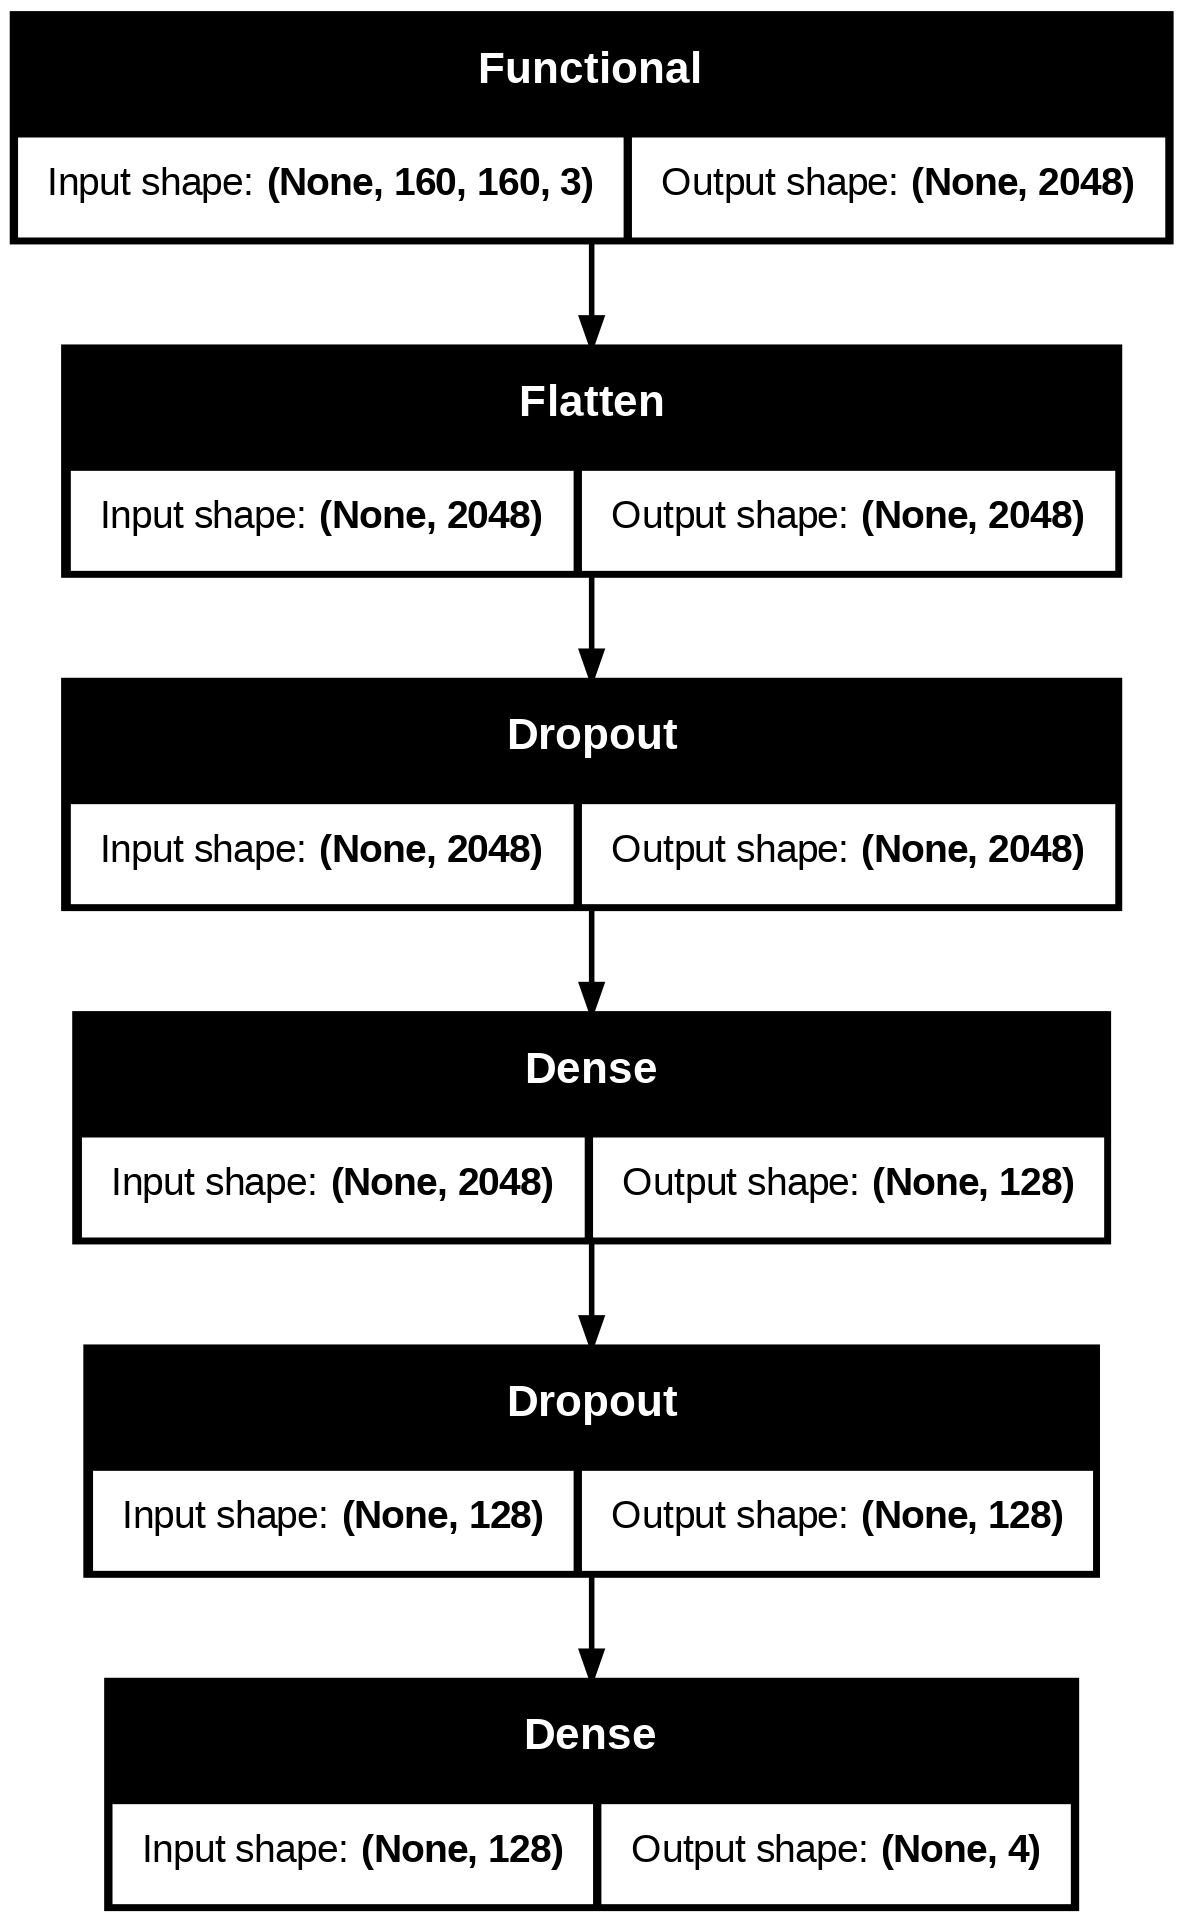

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the path to save the best model
checkpoint_path = "/content/drive/MyDrive/Brain Tumor Classification/Xception_checkpoint_1.keras"

# Set up early stopping and model checkpointing
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor validation loss
    patience=5,             # Stop training after 5 epochs without improvement
    restore_best_weights=True # Restore weights of the best epoch
)

model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,  # Path to save the model file
    monitor='val_loss',        # Monitor validation loss
    save_best_only=True,       # Only save the model with the best val_loss
    verbose=1                  # Print updates when the model is saved
)

# Train the model with the callbacks
hist = model.fit(
    tr_gen,
    epochs=30,
    validation_data=valid_gen,
    shuffle=False,
    callbacks=[early_stopping, model_checkpoint]  # Add callbacks here
)


Epoch 1/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7471 - loss: 0.6673 - precision_1: 0.8234 - recall_1: 0.6553 
Epoch 1: val_loss improved from inf to 0.26638, saving model to /content/drive/MyDrive/Brain Tumor Classification/Xception_checkpoint_1.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 2100s 12s/step - accuracy: 0.7477 - loss: 0.6657 - precision_1: 0.8239 - recall_1: 0.6562 - val_accuracy: 0.8992 - val_loss: 0.2664 - val_precision_1: 0.9095 - val_recall_1: 0.8901
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9472 - loss: 0.1579 - precision_1: 0.9525 - recall_1: 0.9392
Epoch 2: val_loss improved from 0.26638 to 0.10803, saving model to /content/drive/MyDrive/Brain Tumor Classification/Xception_checkpoint_1.keras
179/179 ━━━━━━━━━━━━━━━━━━━━ 94s 525ms/step - accuracy: 0.9472 - loss: 0.1578 - precision_1: 0.9526 - recall_1: 0.9393 - val_accuracy: 0.9634 - val_loss: 0.1080 - val_precision_1: 0.9677 - val_recall_1: 0.9618
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━

In [ ]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'precision_1', 'recall_1', 'val_accuracy', 'val_loss', 'val_precision_1', 'val_recall_1'])

In [ ]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Flatten, Dropout, Dense
# from tensorflow.keras.applications import Xception
# from tensorflow.keras.optimizers import Adamax
# from tensorflow.keras.metrics import Precision, Recall
# import tensorflow as tf

# # Define the model architecture again
# img_shape = (160, 160, 3)
# base_model = Xception(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')

# model = Sequential([
#     base_model,
#     Flatten(),
#     Dropout(rate=0.3),
#     Dense(128, activation='relu'),
#     Dropout(rate=0.25),
#     Dense(4, activation='softmax')
# ])

# # Compile the model to initialize it properly
# model.compile(optimizer=Adamax(learning_rate=0.001),
#               loss='categorical_crossentropy',
#               metrics=['accuracy', Precision(), Recall()])

# # Build the model by calling it on a sample input
# model(tf.random.normal([1, *img_shape]))  # Pass a sample input to build the model

# # Load the weights from the checkpoint
# model.load_weights(checkpoint_path)


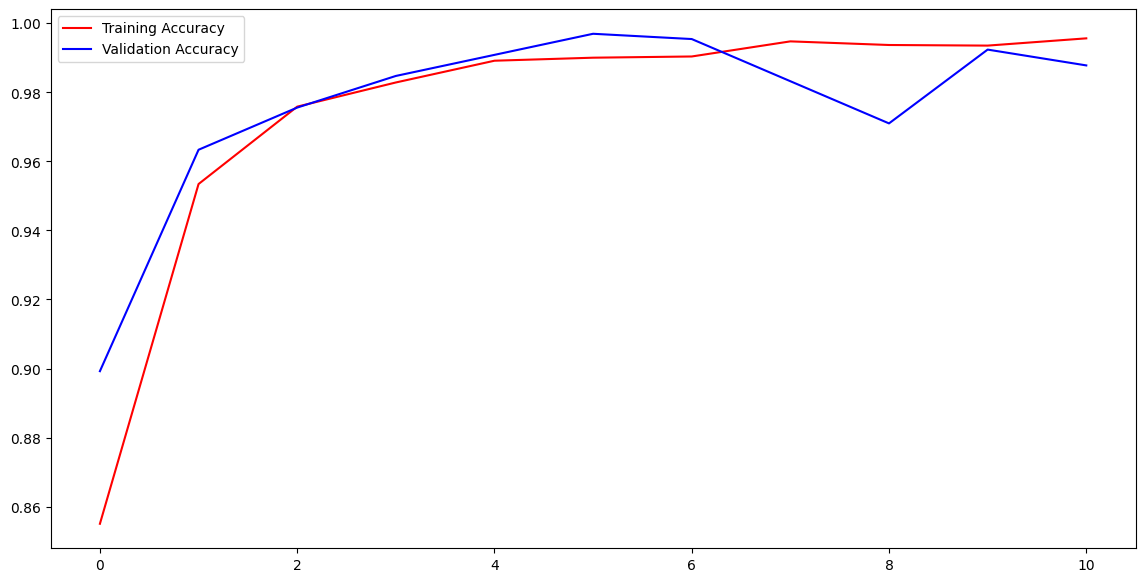

In [ ]:
# plot history2
import matplotlib.pyplot as plt
import seaborn as sns
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,acc,'r',label="Training Accuracy")
plt.plot(epochs,val_acc,'b',label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()

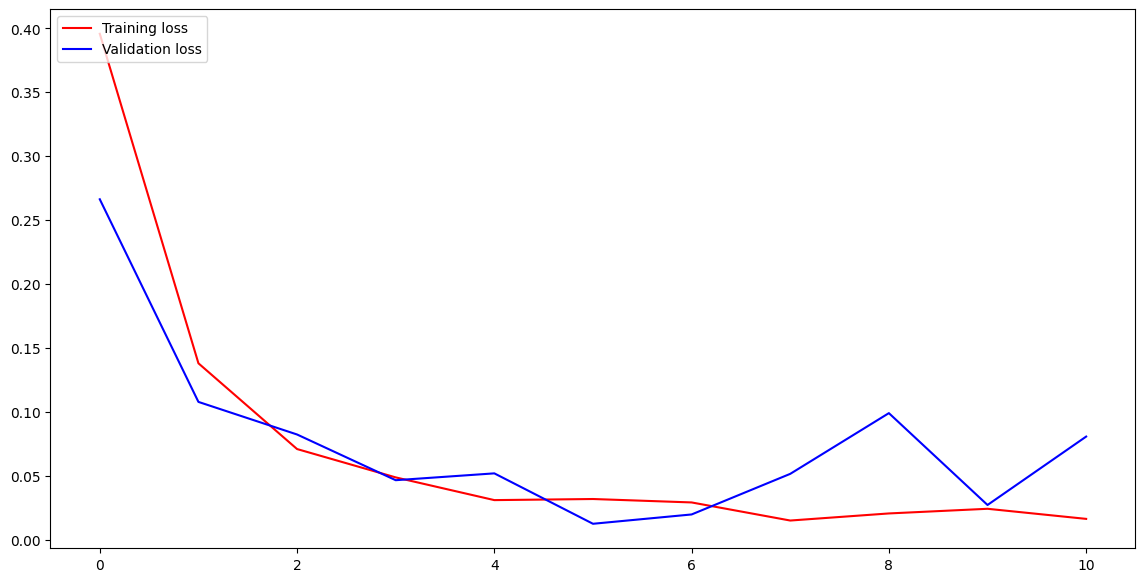

In [ ]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(14,7))
plt.plot(epochs,loss,'r',label="Training loss")
plt.plot(epochs,val_loss,'b',label="Validation loss")
plt.legend(loc='upper left')
plt.show()

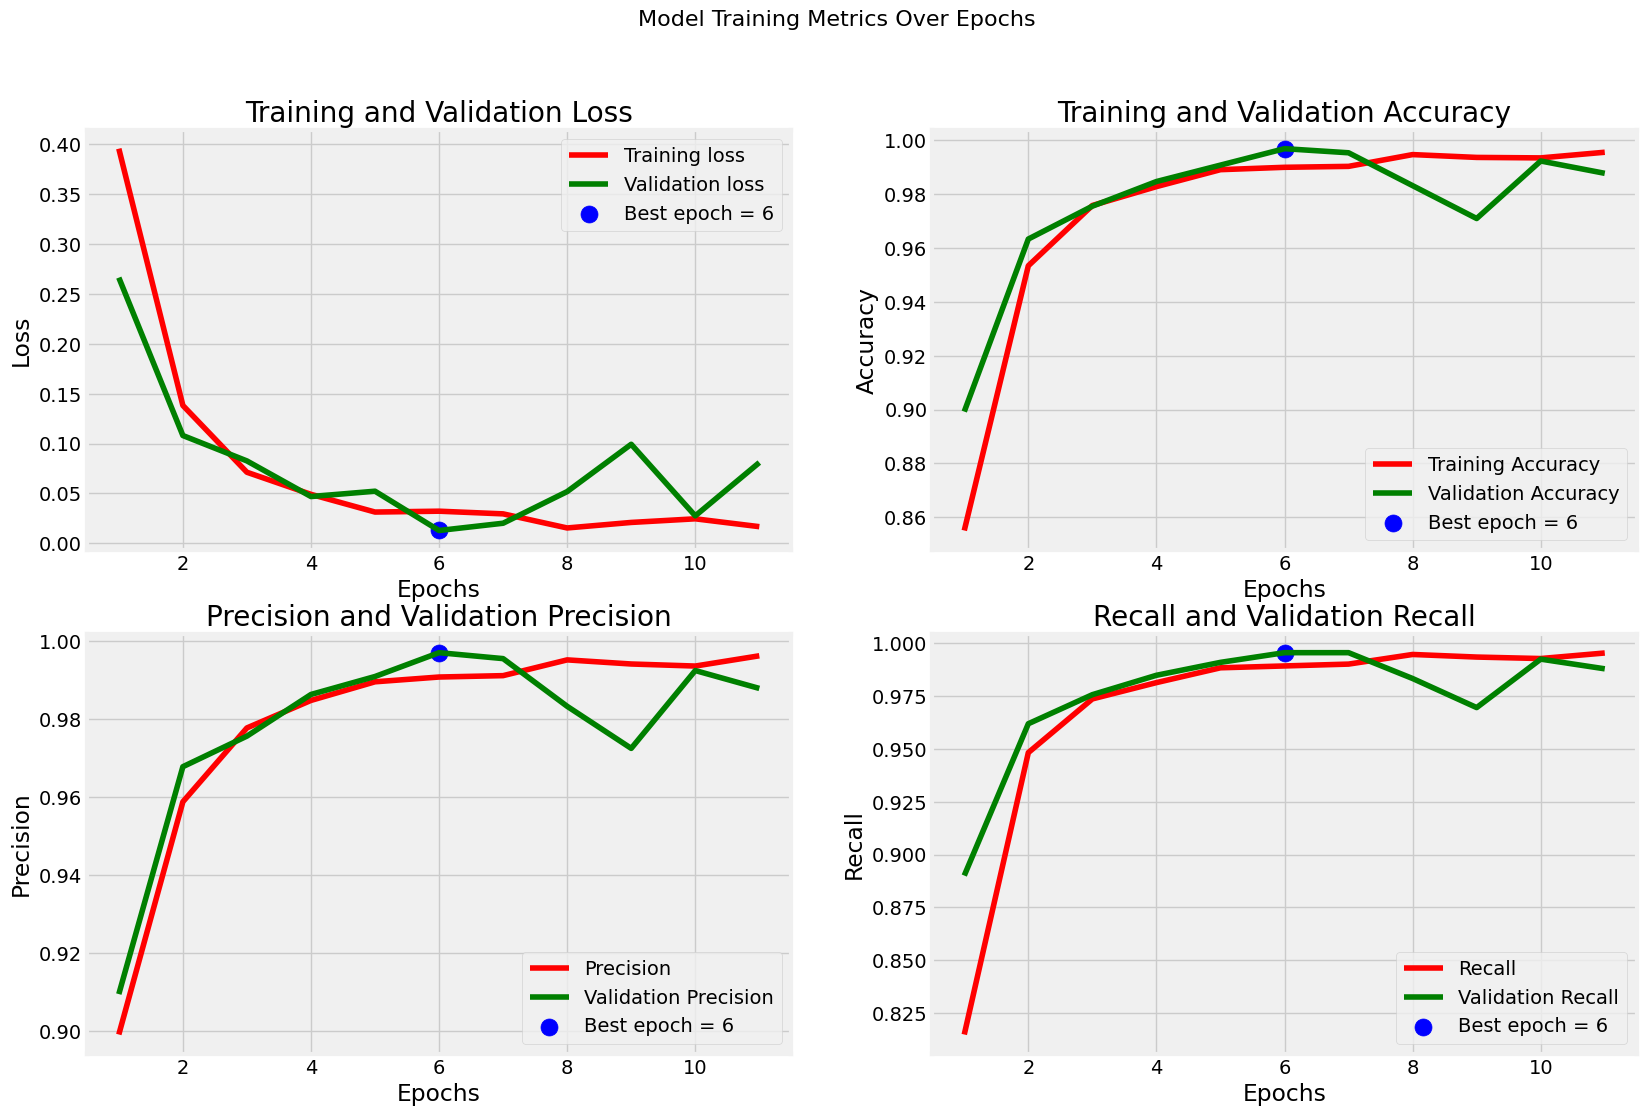

In [ ]:
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision_1']
tr_recall = hist.history['recall_1']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision_1']
val_recall = hist.history['val_recall_1']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
index_precision = np.argmax(val_per)
per_highest = val_per[index_precision]
index_recall = np.argmax(val_recall)
recall_highest = val_recall[index_recall]

Epochs = [i + 1 for i in range(len(tr_acc))]
loss_label = f'Best epoch = {str(index_loss + 1)}'
acc_label = f'Best epoch = {str(index_acc + 1)}'
per_label = f'Best epoch = {str(index_precision + 1)}'
recall_label = f'Best epoch = {str(index_recall + 1)}'


plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')


plt.subplot(2, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(Epochs, tr_per, 'r', label='Precision')
plt.plot(Epochs, val_per, 'g', label='Validation Precision')
plt.scatter(index_precision + 1, per_highest, s=150, c='blue', label=per_label)
plt.title('Precision and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(Epochs, tr_recall, 'r', label='Recall')
plt.plot(Epochs, val_recall, 'g', label='Validation Recall')
plt.scatter(index_recall + 1, recall_highest, s=150, c='blue', label=recall_label)
plt.title('Recall and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
plt.show()

In [ ]:
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")


179/179 ━━━━━━━━━━━━━━━━━━━━ 72s 403ms/step - accuracy: 0.9967 - loss: 0.0116 - precision_1: 0.9967 - recall_1: 0.9967
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 410ms/step - accuracy: 0.9907 - loss: 0.0584 - precision_1: 0.9907 - recall_1: 0.9907
41/41 ━━━━━━━━━━━━━━━━━━━━ 162s 4s/step - accuracy: 0.9918 - loss: 0.0388 - precision_1: 0.9918 - recall_1: 0.9918
Train Loss: 0.0122
Train Accuracy: 99.68%
--------------------
Validation Loss: 0.0271
Validation Accuracy: 99.54%
--------------------
Test Loss: 0.0339
Test Accuracy: 99.54%


In [ ]:
preds = model.predict(ts_gen)
y_pred = np.argmax(preds, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step


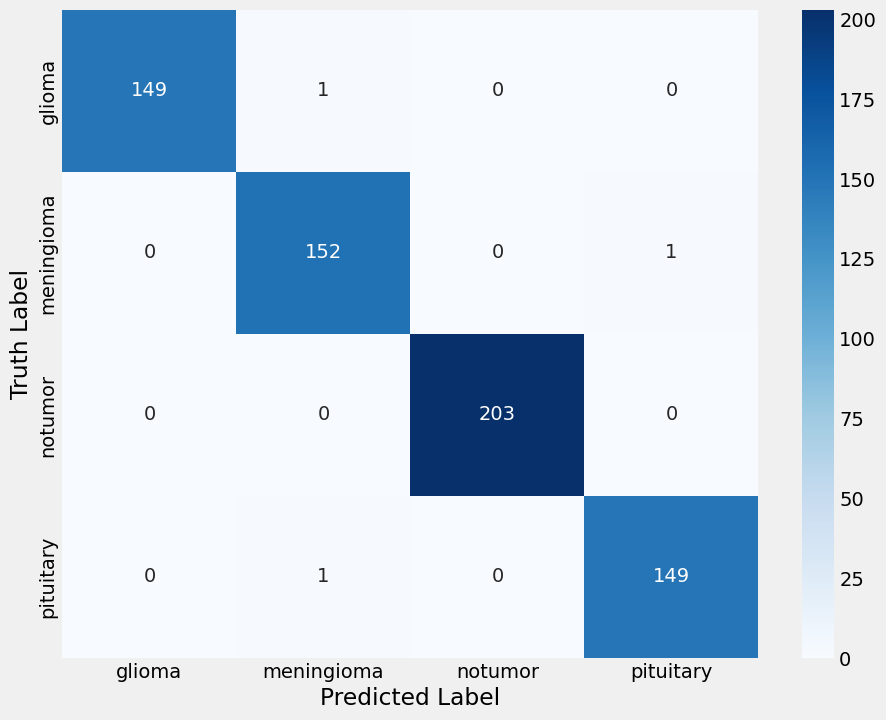

In [ ]:
cm = confusion_matrix(ts_gen.classes, y_pred)
labels = list(class_dict.keys())
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

In [ ]:
clr = classification_report(ts_gen.classes, y_pred)
print(clr)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       150
           1       0.99      0.99      0.99       153
           2       1.00      1.00      1.00       203
           3       0.99      0.99      0.99       150

    accuracy                           1.00       656
   macro avg       1.00      1.00      1.00       656
weighted avg       1.00      1.00      1.00       656

